In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from torchsummary import summary

In [2]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from predict import predict
from open_data import open_data, create_global_batch,get_df_stats,apply_norm
from dataset import RadarDataset,RadarCollate
from encoder_decoder_clean import lstm_seq2seq
from simple_model import LSTM
from train import train

In [3]:
PATH_CSV="/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv" #"/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'
DAYS_INPUT=7
WINDOW_LABEL=7
INPUT_SIZE=(DAYS_INPUT)*24*4
OUTPUT_SIZE=(WINDOW_LABEL)*24*4
TOTAL_DAYS=100

In [4]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [5]:
batch_df=create_global_batch(df1, window_x_day=DAYS_INPUT, window_label_day=WINDOW_LABEL, gap_acquisition=1, tot_len_day=TOTAL_DAYS)

Building batch 0 
 x begin 2018-01-02 label begin 2018-01-09 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-03 label begin 2018-01-10 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-04 label begin 2018-01-11 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-05 label begin 2018-01-12 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-06 label begin 2018-01-13 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-07 label begin 2018-01-14 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-08 label begin 2018-01-15 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-09 label begin 2018-01-16 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-10 label begin 2018-01-17 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-11 label begin 2018-01-18 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-12 label begin 2018-01-19 end period 2018-03-29 
Building batch 0 
 x begin 2018-01-13 label begin 2018-01-20 end period 2018

In [6]:
batch_df

,vol_data_x,vol_label_y
0,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11...."
1,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13...."
2,"[32.0, 25.0, 20.0, 25.0, 20.0, 19.0, 18.0, 8.0...","[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16...."
3,"[56.0, 54.0, 41.0, 39.0, 27.0, 28.0, 32.0, 17....","[83.0, 64.0, 45.0, 47.0, 29.0, 37.0, 26.0, 24...."
4,"[75.0, 62.0, 49.0, 42.0, 42.0, 44.0, 27.0, 23....","[80.0, 65.0, 59.0, 64.0, 42.0, 37.0, 32.0, 27...."
5,"[24.0, 26.0, 16.0, 17.0, 10.0, 8.0, 10.0, 11.0...","[35.0, 24.0, 26.0, 20.0, 22.0, 15.0, 11.0, 12...."
6,"[33.0, 38.0, 45.0, 30.0, 25.0, 10.0, 13.0, 15....","[37.0, 25.0, 26.0, 30.0, 12.0, 25.0, 12.0, 10...."
7,"[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....","[29.0, 34.0, 20.0, 25.0, 15.0, 10.0, 13.0, 12...."
8,"[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....","[47.0, 26.0, 36.0, 14.0, 19.0, 14.0, 16.0, 12...."
9,"[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....","[32.0, 36.0, 21.0, 33.0, 23.0, 15.0, 8.0, 10.0..."


In [7]:
#batch_df["mean_x"]=batch_df["vol_data_x"].apply(lambda x : np.mean(x))
#batch_df["std_x"]=batch_df["vol_data_x"].apply(lambda x : np.std(x))
#batch_df["mean_y"]=batch_df["vol_label_y"].apply(lambda x : np.mean(x))
# batch_df

In [8]:
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


In [9]:
get_df_stats(new_data,["vol_data_x_norm","vol_label_y_norm"])

(0.0, 1.0)

In [10]:
batch_df

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....",0.0,789.0,0.0,635.0,"[0.015116279069767442, 0.005813953488372093, 0...","[0.044186046511627906, 0.044186046511627906, 0...",0.000000,0.917442,0.0,0.738372
1,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....",0.0,505.0,0.0,635.0,"[0.03953488372093023, 0.03372093023255814, 0.0...","[0.040697674418604654, 0.040697674418604654, 0...",0.000000,0.587209,0.0,0.738372
2,"[32.0, 25.0, 20.0, 25.0, 20.0, 19.0, 18.0, 8.0...","[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....",0.0,635.0,0.0,499.0,"[0.037209302325581395, 0.029069767441860465, 0...","[0.044186046511627906, 0.03953488372093023, 0....",0.000000,0.738372,0.0,0.580233
3,"[56.0, 54.0, 41.0, 39.0, 27.0, 28.0, 32.0, 17....","[83.0, 64.0, 45.0, 47.0, 29.0, 37.0, 26.0, 24....",0.0,635.0,0.0,499.0,"[0.06511627906976744, 0.06279069767441861, 0.0...","[0.09651162790697675, 0.07441860465116279, 0.0...",0.000000,0.738372,0.0,0.580233
4,"[75.0, 62.0, 49.0, 42.0, 42.0, 44.0, 27.0, 23....","[80.0, 65.0, 59.0, 64.0, 42.0, 37.0, 32.0, 27....",0.0,635.0,0.0,499.0,"[0.0872093023255814, 0.07209302325581396, 0.05...","[0.09302325581395349, 0.0755813953488372, 0.06...",0.000000,0.738372,0.0,0.580233
5,"[24.0, 26.0, 16.0, 17.0, 10.0, 8.0, 10.0, 11.0...","[35.0, 24.0, 26.0, 20.0, 22.0, 15.0, 11.0, 12....",0.0,635.0,0.0,499.0,"[0.027906976744186046, 0.030232558139534883, 0...","[0.040697674418604654, 0.027906976744186046, 0...",0.000000,0.738372,0.0,0.580233
6,"[33.0, 38.0, 45.0, 30.0, 25.0, 10.0, 13.0, 15....","[37.0, 25.0, 26.0, 30.0, 12.0, 25.0, 12.0, 10....",0.0,635.0,0.0,499.0,"[0.03837209302325582, 0.044186046511627906, 0....","[0.04302325581395349, 0.029069767441860465, 0....",0.000000,0.738372,0.0,0.580233
7,"[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....","[29.0, 34.0, 20.0, 25.0, 15.0, 10.0, 13.0, 12....",0.0,635.0,0.0,499.0,"[0.044186046511627906, 0.044186046511627906, 0...","[0.03372093023255814, 0.03953488372093023, 0.0...",0.000000,0.738372,0.0,0.580233
8,"[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....","[47.0, 26.0, 36.0, 14.0, 19.0, 14.0, 16.0, 12....",0.0,635.0,0.0,810.0,"[0.040697674418604654, 0.040697674418604654, 0...","[0.05465116279069768, 0.030232558139534883, 0....",0.000000,0.738372,0.0,0.941860
9,"[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....","[32.0, 36.0, 21.0, 33.0, 23.0, 15.0, 8.0, 10.0...",0.0,499.0,0.0,860.0,"[0.044186046511627906, 0.03953488372093023, 0....","[0.037209302325581395, 0.04186046511627907, 0....",0.000000,0.580233,0.0,1.000000


In [11]:
new_data

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....",0.0,789.0,0.0,635.0,"[0.015116279069767442, 0.005813953488372093, 0...","[0.044186046511627906, 0.044186046511627906, 0...",0.000000,0.917442,0.0,0.738372
1,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....",0.0,505.0,0.0,635.0,"[0.03953488372093023, 0.03372093023255814, 0.0...","[0.040697674418604654, 0.040697674418604654, 0...",0.000000,0.587209,0.0,0.738372
2,"[32.0, 25.0, 20.0, 25.0, 20.0, 19.0, 18.0, 8.0...","[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....",0.0,635.0,0.0,499.0,"[0.037209302325581395, 0.029069767441860465, 0...","[0.044186046511627906, 0.03953488372093023, 0....",0.000000,0.738372,0.0,0.580233
3,"[56.0, 54.0, 41.0, 39.0, 27.0, 28.0, 32.0, 17....","[83.0, 64.0, 45.0, 47.0, 29.0, 37.0, 26.0, 24....",0.0,635.0,0.0,499.0,"[0.06511627906976744, 0.06279069767441861, 0.0...","[0.09651162790697675, 0.07441860465116279, 0.0...",0.000000,0.738372,0.0,0.580233
4,"[75.0, 62.0, 49.0, 42.0, 42.0, 44.0, 27.0, 23....","[80.0, 65.0, 59.0, 64.0, 42.0, 37.0, 32.0, 27....",0.0,635.0,0.0,499.0,"[0.0872093023255814, 0.07209302325581396, 0.05...","[0.09302325581395349, 0.0755813953488372, 0.06...",0.000000,0.738372,0.0,0.580233
5,"[24.0, 26.0, 16.0, 17.0, 10.0, 8.0, 10.0, 11.0...","[35.0, 24.0, 26.0, 20.0, 22.0, 15.0, 11.0, 12....",0.0,635.0,0.0,499.0,"[0.027906976744186046, 0.030232558139534883, 0...","[0.040697674418604654, 0.027906976744186046, 0...",0.000000,0.738372,0.0,0.580233
6,"[33.0, 38.0, 45.0, 30.0, 25.0, 10.0, 13.0, 15....","[37.0, 25.0, 26.0, 30.0, 12.0, 25.0, 12.0, 10....",0.0,635.0,0.0,499.0,"[0.03837209302325582, 0.044186046511627906, 0....","[0.04302325581395349, 0.029069767441860465, 0....",0.000000,0.738372,0.0,0.580233
7,"[38.0, 38.0, 26.0, 21.0, 26.0, 22.0, 18.0, 11....","[29.0, 34.0, 20.0, 25.0, 15.0, 10.0, 13.0, 12....",0.0,635.0,0.0,499.0,"[0.044186046511627906, 0.044186046511627906, 0...","[0.03372093023255814, 0.03953488372093023, 0.0...",0.000000,0.738372,0.0,0.580233
8,"[35.0, 35.0, 35.0, 23.0, 23.0, 14.0, 13.0, 13....","[47.0, 26.0, 36.0, 14.0, 19.0, 14.0, 16.0, 12....",0.0,635.0,0.0,810.0,"[0.040697674418604654, 0.040697674418604654, 0...","[0.05465116279069768, 0.030232558139534883, 0....",0.000000,0.738372,0.0,0.941860
9,"[38.0, 34.0, 32.0, 23.0, 29.0, 15.0, 22.0, 16....","[32.0, 36.0, 21.0, 33.0, 23.0, 15.0, 8.0, 10.0...",0.0,499.0,0.0,860.0,"[0.044186046511627906, 0.03953488372093023, 0....","[0.037209302325581395, 0.04186046511627907, 0....",0.000000,0.580233,0.0,1.000000


In [12]:
#get_df_stats(new_data,columns=["vol_data_x_norm","vol_label_y_norm"])

In [13]:
# sample_rate = 16000
batch_size = 1

In [14]:
#normalize=transforms.Compose([
#    transforms.ToTensor(),
  #  transforms.Normalize(mean=[df_mean],
                       #  std=[df_std])
#])
fullset = RadarDataset(dataframe=batch_df,transform=None)
ptrain,pval,ptest=0.8,0.05,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest,shuffle=False)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest),shuffle=False)

(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)
(672,)


In [15]:
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [16]:
print(traindataset)

[(array([0.01511628, 0.00581395, 0.01627907, 0.01744186, 0.01046512,
       0.00465116, 0.00697674, 0.00116279, 0.00465116, 0.00116279,
       0.00581395, 0.00232558, 0.00465116, 0.00697674, 0.00581395,
       0.00348837, 0.00813953, 0.00930233, 0.01395349, 0.01511628,
       0.02674419, 0.02906977, 0.03604651, 0.06627907, 0.08953488,
       0.10348837, 0.15116279, 0.18139535, 0.25232558, 0.31744186,
       0.33372093, 0.49069767, 0.45116279, 0.39069767, 0.46976744,
       0.44534884, 0.51860465, 0.52209302, 0.53953488, 0.56744186,
       0.54186047, 0.50930233, 0.43255814, 0.43488372, 0.44418605,
       0.46627907, 0.48953488, 0.5       , 0.45116279, 0.43604651,
       0.45581395, 0.47674419, 0.43837209, 0.40813953, 0.44186047,
       0.45581395, 0.4372093 , 0.42906977, 0.44651163, 0.91744186,
       0.43488372, 0.5       , 0.45348837, 0.54418605, 0.51744186,
       0.30348837, 0.34069767, 0.31395349, 0.07674419, 0.07209302,
       0.05348837, 0.06395349, 0.07093023, 0.29069767, 0.320

In [17]:
c= 0
for x in trainloader:
    print("batch number {}".format(c))
    print(x[0].shape, x[1].shape, "\n")
    #print(x)
    c+=1

batch number 0
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 1
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 2
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 3
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 4
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 5
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 6
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 7
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 8
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 9
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 10
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 11
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 12
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 13
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 14
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 15
torch.Size([1, 672]) torch.Size([1, 672]) 

batch number 16
torch.Size([1, 672]) torch.Size([1

## Modèle 1 

In [21]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr = 0.05
n_epochs = 300
iterations_per_epoch = len(trainloader)
name_model = "simple_model_smalldataset_lr5e-2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model=LSTM(input_size=input_dim,hidden_size=hidden_dim,output_size=output_dim)


In [22]:
print(model)

LSTM(
  (lstm): LSTM(672, 256)
  (linear): Linear(in_features=256, out_features=672, bias=True)
)


In [23]:
iteration,loss_train_list,loss_val_list=train(model, trainloader, valloader, lr=lr, n_epochs=n_epochs, name_model=name_model, device=device, ite_print=5,save=True)

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 672])) that is different to the input size (torch.Size([672])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 661])) that is different to the input size (torch.Size([672])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (672) must match the size of tensor b (661) at non-singleton dimension 1

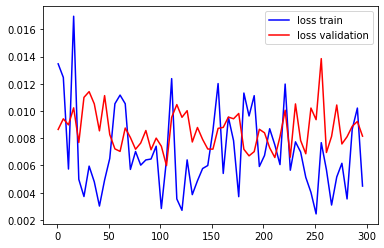

In [21]:
fig,ax=plt.subplots()
ax.plot(iteration,loss_train_list,"b",label="loss train")
ax.plot(iteration,loss_val_list,"r",label="loss validation")
ax.legend()

## Modèle 2 

In [30]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr2 = 0.001
n_epochs = 700
iterations_per_epoch = len(trainloader)
#name_model = "model2"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=LSTM()
name_model="simple_model_smalldataset_lre-3"


In [31]:
iteration2,loss_train_list2,loss_val_list2=train(model, trainloader, valloader, lr=lr2, n_epochs=n_epochs, name_model=name_model, device=device,ite_print=2,save=True)

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 0.005454640835523605 loss val 0.019565336406230927


/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 3 loss train 0.004216549452394247 loss val 0.01947006769478321
epoch 5 loss train 0.000931077403947711 loss val 0.011358407326042652
epoch 7 loss train 0.00086345209274441 loss val 0.01778198592364788
epoch 9 loss train 0.002096867887303233 loss val 0.017888562753796577
epoch 11 loss train 0.0012445602333173156 loss val 0.014794901944696903
epoch 13 loss train 0.0023138567339628935 loss val 0.02044106461107731
epoch 15 loss train 0.0053533571772277355 loss val 0.018725628033280373
epoch 17 loss train 0.0007516025216318667 loss val 0.017486294731497765
epoch 19 loss train 0.0014340252382680774 loss val 0.01719430461525917
epoch 21 loss train 0.0015782435657456517 loss val 0.010984178632497787
epoch 23 loss train 0.00040644261753186584 loss val 0.016249896958470345
epoch 25 loss train 0.0009770868346095085 loss val 0.016061807051301003
epoch 27 loss train 0.002761108335107565 loss val 0.014107983559370041
epoch 29 loss train 0.0006891785305924714 loss val 0.013165658339858055
epoch

epoch 231 loss train 0.0002487568708602339 loss val 0.007676332723349333
epoch 233 loss train 0.00018267185078002512 loss val 0.009887339547276497
epoch 235 loss train 0.0003408170014154166 loss val 0.008382551372051239
epoch 237 loss train 0.00017515204672235996 loss val 0.008659121580421925
epoch 239 loss train 0.00024860387202352285 loss val 0.009384454227983952
epoch 241 loss train 0.00036122361780144274 loss val 0.00702689727768302
epoch 243 loss train 0.00026659530703909695 loss val 0.008646761067211628
epoch 245 loss train 0.0002648349618539214 loss val 0.009567922912538052
epoch 247 loss train 0.0001566961145726964 loss val 0.00930507481098175
epoch 249 loss train 0.00036328009446151555 loss val 0.00721832225099206
epoch 251 loss train 0.000129295774968341 loss val 0.009387335740029812
epoch 253 loss train 0.00019472432904876769 loss val 0.008769086562097073
epoch 255 loss train 0.00017699234012980014 loss val 0.008656025864183903
epoch 257 loss train 0.0003874218091368675 loss

epoch 455 loss train 0.00010678175021894276 loss val 0.004816307220607996
epoch 457 loss train 0.00017079641111195087 loss val 0.00546460272744298
epoch 459 loss train 0.000292343640467152 loss val 0.004682841710746288
epoch 461 loss train 0.000280668493360281 loss val 0.005164720583707094
epoch 463 loss train 0.00030840144609101117 loss val 0.004850449506193399
epoch 465 loss train 0.00013290488277561963 loss val 0.004576509818434715
epoch 467 loss train 0.0003023953759111464 loss val 0.004514734726399183
epoch 469 loss train 8.616894774604589e-05 loss val 0.005029585678130388
epoch 471 loss train 0.00011039422679459676 loss val 0.004837770946323872
epoch 473 loss train 0.0002068777976091951 loss val 0.004786851815879345
epoch 475 loss train 0.00025324858142994344 loss val 0.0046067568473517895
epoch 477 loss train 0.0002747434482444078 loss val 0.004785604774951935
epoch 479 loss train 0.0002186393685406074 loss val 0.004830763675272465
epoch 481 loss train 0.0002288208925165236 loss

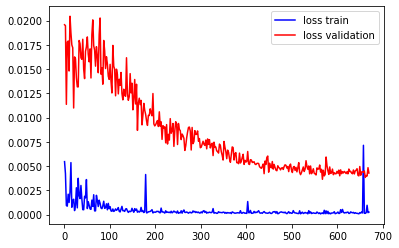

In [32]:
fig,ax=plt.subplots()
ax.plot(iteration2,loss_train_list2,"b",label="loss train")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation")
ax.legend()

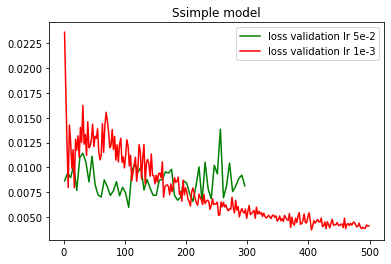

In [25]:
fig,ax=plt.subplots()
ax.set_title("Ssimple model")
ax.plot(iteration,loss_val_list,"green",label="loss validation lr 5e-2")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation lr 1e-3")
ax.legend()

In [33]:
PATH_MODEL="/Users/iris/Code/RadarTrafficData/models/simple_model_smalldataset_lr5e-2.pt"
prediction, gt, mse_list=predict(PATH_MODEL,testloader)

In [34]:
## print(i)

tensor([[0.0473, 0.0308, 0.0206, 0.0267, 0.0175, 0.0247, 0.0226, 0.0195, 0.0113,
         0.0072, 0.0062, 0.0103, 0.0134, 0.0134, 0.0082, 0.0154, 0.0185, 0.0134,
         0.0175, 0.0154, 0.0257, 0.0308, 0.0329, 0.0647, 0.0689, 0.1233, 0.1449,
         0.1922, 0.2559, 0.3001, 0.3649, 0.3392, 0.3063, 0.2898, 0.2652, 0.3104,
         0.3135, 0.2487, 0.2230, 0.2456, 0.2744, 0.3114, 0.4080, 0.3741, 0.3792,
         0.3700, 0.4101, 0.4152, 0.4203, 0.3453, 0.3947, 0.3720, 0.2323, 0.3977,
         0.3864, 0.4286, 0.3803, 0.3669, 0.4080, 0.4265, 0.4275, 0.3947, 0.4645,
         0.3751, 0.4543, 0.4707, 0.4758, 0.2055, 0.4687, 0.4748, 0.4676, 0.2148,
         0.2230, 0.4728, 0.2035, 0.4368, 0.4101, 0.3371, 0.3042, 0.2539, 0.2210,
         0.1994, 0.1387, 0.1387, 0.1429, 0.1644, 0.1326, 0.1901, 0.1439, 0.1223,
         0.1408, 0.1346, 0.1357, 0.1089, 0.0832, 0.0997, 0.0853, 0.0647, 0.0791,
         0.0360, 0.0380, 0.0277, 0.0247, 0.0257, 0.0175, 0.0134, 0.0144, 0.0236,
         0.0082, 0.0123, 0.0

In [35]:
#print(prediction)
#print(gt)

[tensor([[0.0534, 0.0401, 0.0298, 0.0308, 0.0236, 0.0195, 0.0123, 0.0113, 0.0062,
         0.0051, 0.0072, 0.0103, 0.0092, 0.0103, 0.0031, 0.0072, 0.0164, 0.0144,
         0.0195, 0.0103, 0.0206, 0.0298, 0.0277, 0.0432, 0.0761, 0.0771, 0.1131,
         0.1346, 0.2014, 0.2744, 0.3299, 0.4388, 0.4388, 0.4758, 0.3998, 0.4029,
         0.4132, 0.4347, 0.3381, 0.3782, 0.3505, 0.3895, 0.3916, 0.3823, 0.3803,
         0.3895, 0.3977, 0.4409, 0.4152, 0.4738, 0.3505, 0.3905, 0.3402, 0.3659,
         0.3854, 0.3998, 0.4060, 0.4152, 0.3546, 0.3936, 0.3926, 0.4409, 0.4070,
         0.2066, 0.4173, 0.2436, 0.4697, 0.4717, 0.4440, 0.4964, 0.2518, 0.5077,
         0.0103, 0.4687, 0.4800, 0.4841, 0.2292, 0.4758, 0.3823, 0.3577, 0.2847,
         0.2384, 0.1953, 0.2117, 0.1686, 0.1377, 0.1665, 0.1562, 0.1665, 0.1644,
         0.1459, 0.1418, 0.1007, 0.1007, 0.0832, 0.0658]]), tensor([[0.0452, 0.0360, 0.0319, 0.0267, 0.0123, 0.0164, 0.0267, 0.0113, 0.0144,
         0.0134, 0.0062, 0.0113, 0.0134, 0.0041,

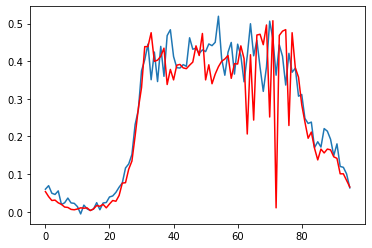

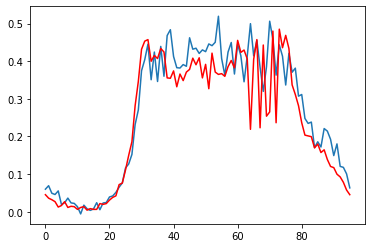

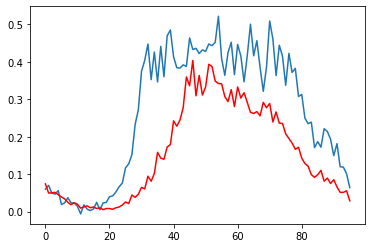

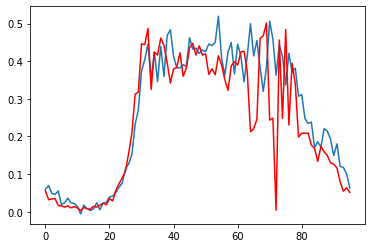

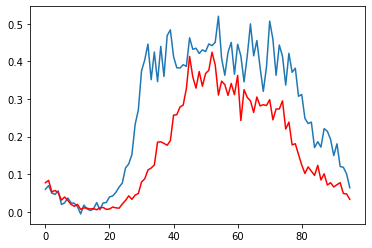

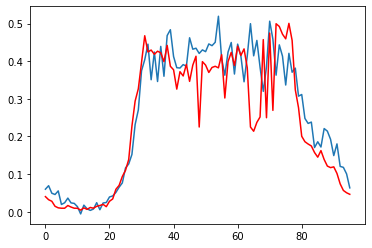

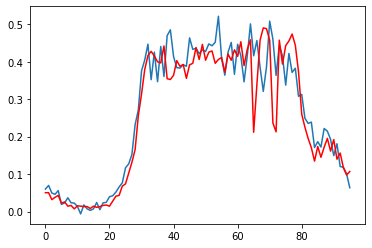

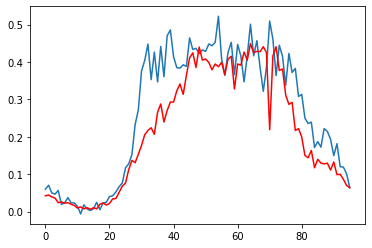

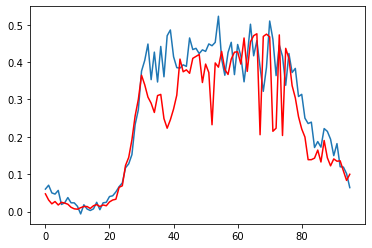

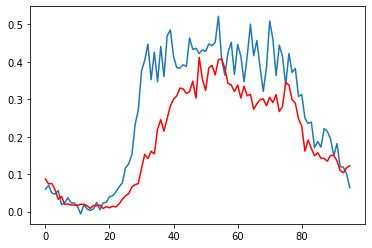

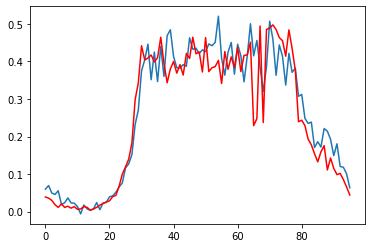

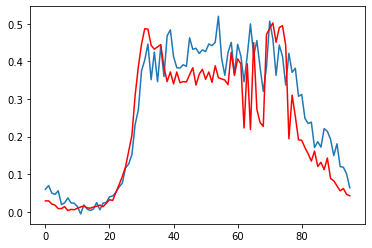

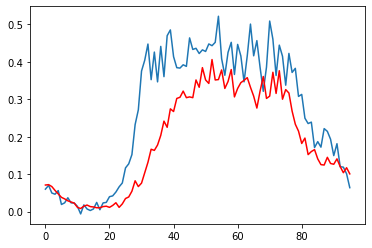

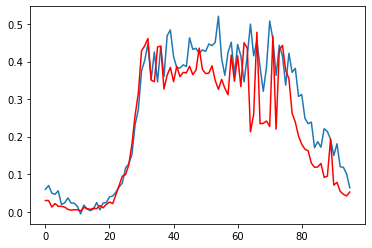

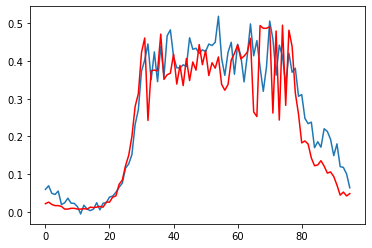

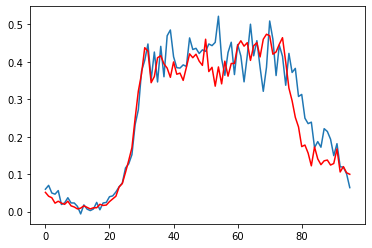

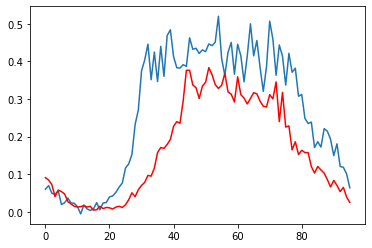

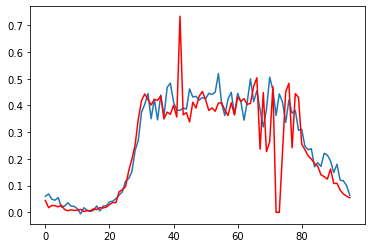

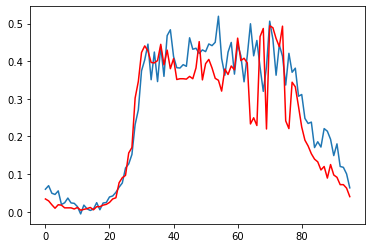

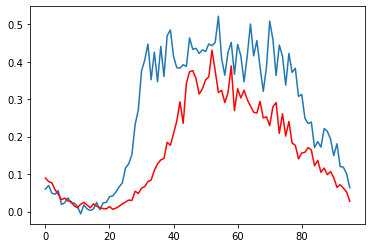

In [39]:
for i in range(20):
    fig,ax=plt.subplots()
    arr_pred=prediction[i].detach().numpy()
    ax.plot([i for i in range(len(arr_pred))],arr_pred)
    arr_gt=gt[i].detach().numpy()
    ax.plot([i for i in range(len(arr_pred))],arr_gt.ravel(),"r")

## LSTM Model

In [19]:
from encoder_decoder import lstm_wrapper

In [20]:
model_encoder_decoder=lstm_wrapper(input_size=input_dim,hidden_size=hidden_dim,target_len=output_dim)

In [19]:
model_encoder_decoder.train_model(trainloader, n_epochs=epochs, target_len=output_dim, batch_size=1, teacher_forcing_ratio=0.5,learning_rate=0.01,save=False,name_model="model")

NameError: name 'model_encoder_decoder' is not defined

In [18]:
input_dim = 1   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1
epochs=100
batch_size=1

In [19]:
model_seq2seq=lstm_seq2seq(1, hidden_dim)

In [21]:
iteration,losses,loss_val_list=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=0.01, dynamic_tf=False,ite_print=1)

100%|██████████| 100/100 [10:05:26<00:00, 363.27s/it, loss=nan]  


In [ ]:
iteration2,losses2,loss_val_list2=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=0.001, dynamic_tf=False,name_model="encode_decod_lre-3")

In [22]:
 torch.save(model_seq2seq, "../models/encode_decoder_i100" + ".pt")

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_seq2seq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_decoder. It won't b

ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

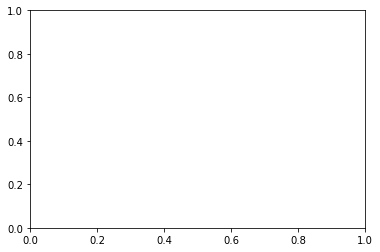

In [23]:
plt.plot(iteration,losses)